In [1]:
import numpy as np
import numpyro as npyro
import matplotlib.pyplot as plt
import pandas as pd
import numpyro.distributions as dist
import jax
from numpyro.infer import MCMC, NUTS 

### Load data

In [2]:
data = pd.read_csv("weights_baby.csv")

In [3]:
np.unique(data.ID.values)

array([  33,   55,   63,   70,   92,  103,  116,  150,  167,  170,  185,
        252,  293,  309,  432,  433,  475,  565,  747,  788,  871,  946,
       1030, 1184, 1207, 1297, 1306, 1360, 1371, 1374, 1405, 1503, 1629,
       1639, 1740, 1789, 1815, 1915, 1973, 2045, 2087, 2187, 2197, 2199,
       2213, 2233, 2237, 2249, 2283, 2328, 2371, 2394, 2461, 2499, 2507,
       2525, 2532, 2533, 2583, 2643, 2718, 2774, 2798, 2812, 2854, 2870,
       2889, 2895, 2913, 2953, 2973, 2991, 3038, 3069, 3078, 3135, 3144,
       3180, 3216, 3257, 3264, 3332, 3358, 3438, 3491, 3504, 3508, 3512,
       3524, 3555, 3577, 3665, 3685, 3868, 3904, 3921, 3927, 3970, 3987,
       3997])

(array([180., 270., 360., 330., 240., 540., 270., 240., 210., 360.]),
 array([0.09647216, 0.11645502, 0.13643788, 0.15642073, 0.17640359,
        0.19638645, 0.21636931, 0.23635217, 0.25633502, 0.27631788,
        0.29630074]),
 <a list of 10 Patch objects>)

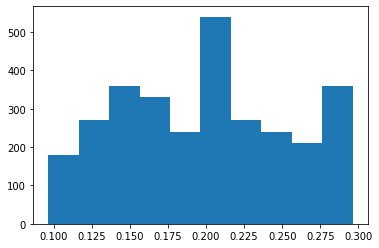

In [4]:
plt.hist(data["sigma"].values)

Values are repeated 

(array([ 6.,  9., 12., 11.,  8., 18.,  9.,  8.,  7., 12.]),
 array([0.09647216, 0.11645502, 0.13643788, 0.15642073, 0.17640359,
        0.19638645, 0.21636931, 0.23635217, 0.25633502, 0.27631788,
        0.29630074]),
 <a list of 10 Patch objects>)

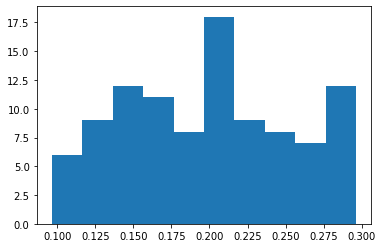

In [5]:
plt.hist(np.unique(data.sigma.values))

### Associate the ID to an incremental number

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
np.unique(data.ID.values)

array([  33,   55,   63,   70,   92,  103,  116,  150,  167,  170,  185,
        252,  293,  309,  432,  433,  475,  565,  747,  788,  871,  946,
       1030, 1184, 1207, 1297, 1306, 1360, 1371, 1374, 1405, 1503, 1629,
       1639, 1740, 1789, 1815, 1915, 1973, 2045, 2087, 2187, 2197, 2199,
       2213, 2233, 2237, 2249, 2283, 2328, 2371, 2394, 2461, 2499, 2507,
       2525, 2532, 2533, 2583, 2643, 2718, 2774, 2798, 2812, 2854, 2870,
       2889, 2895, 2913, 2953, 2973, 2991, 3038, 3069, 3078, 3135, 3144,
       3180, 3216, 3257, 3264, 3332, 3358, 3438, 3491, 3504, 3508, 3512,
       3524, 3555, 3577, 3665, 3685, 3868, 3904, 3921, 3927, 3970, 3987,
       3997])

In [8]:
le = LabelEncoder()

In [9]:
data["myIDs"]=le.fit_transform(data.ID.values)

In [10]:
max_sig = data[data.index==data.sigma.idxmax()]["myIDs"].values[0]
min_sig = data[data.index==data.sigma.idxmin()]["myIDs"].values[0]

In [11]:
num_babies = len(np.unique(data.myIDs.values))

### Create the model (I am now assuming I know the sigma of my distribution)

In [12]:
def model(idx, x, sigma, y=None):
    
    w_mu = npyro.sample("w_mu", dist.Uniform(0., 1.))
    w_scale = npyro.sample("w_scale", dist.Uniform(4., 10.))
    q_mu = npyro.sample("q_mu", dist.Uniform(4., 10.))
    q_scale = npyro.sample("q_scale", dist.Uniform(0., 1.))

    
    ### I have two things num unique babys and num data 
    
    unique_ids = np.unique(idx)
    
    ### Now w and q are unique for eac Plotting the h patient, so I sample over that
    with npyro.plate("ids", len(unique_ids)):
        w = npyro.sample("w", dist.Normal(w_mu, w_scale))
        q = npyro.sample("q", dist.Normal(q_mu, q_scale))

        
    mean = w[idx]*x+q[idx]

    
    with npyro.plate("data", len(x)):
        obs = npyro.sample("obs", dist.Normal(mean, sigma), obs=y)
    
    
    

### During inference

In [13]:
nuts_kernel = NUTS(model)

In [14]:
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000)

In [15]:
rnd_key = jax.random.PRNGKey(0)

In [16]:
x = data["day"].values
ids = data["myIDs"].values
y = data["obs"].values
sigmas = data["sigma"].values

In [17]:
mcmc.run(rnd_key, idx=ids, x=x, sigma=sigmas, y=y)

sample: 100%|██████████| 2500/2500 [00:15<00:00, 162.29it/s, 127 steps of size 4.39e-02. acc. prob=0.87]


In [18]:
sample = mcmc.get_samples()

In [19]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      q[0]      5.02      0.03      5.02      4.98      5.07    298.33      1.00
      q[1]      5.00      0.03      5.00      4.95      5.04   2550.98      1.00
      q[2]      5.01      0.03      5.01      4.97      5.06   1853.51      1.00
      q[3]      5.00      0.02      5.00      4.96      5.04   2734.84      1.00
      q[4]      5.01      0.03      5.01      4.97      5.05   1889.72      1.00
      q[5]      5.01      0.02      5.01      4.97      5.05   2400.22      1.00
      q[6]      4.99      0.03      4.99      4.94      5.03    677.41      1.00
      q[7]      5.00      0.03      5.00      4.95      5.04   1949.40      1.00
      q[8]      4.99      0.03      4.99      4.94      5.03    500.94      1.00
      q[9]      5.01      0.03      5.01      4.96      5.05   1876.96      1.00
     q[10]      4.99      0.03      4.99      4.94      5.03    777.48      1.00
     q[11]      5.00      0

### Doing inference and making predictions

In [20]:
from numpyro.infer import Predictive

In [21]:
predictive = Predictive(model, sample, return_sites=["obs", "sigma_scale", "sigma", "w_mu", "w_scale", "q_mu", "q_scale", "w", "q"])

In [25]:
x = np.linspace(0, 100, 100)
#ids = np.array([max_sig]*len(x)+[min_sig]*len(x)+[2]*len(x)+[3]*len(x)+[4]*len(x))

In [27]:
sigmas_points= data.sigma.values
_, idx = np.unique(sigmas_points, return_index=True)
sigmas_points = sigmas_points[np.sort(idx)]


In [28]:
x = np.concatenate([x]*100)
ids = np.concatenate(np.array([[i]*100 for i in range(num_babies)]))
sigmas = np.concatenate(np.array([[i]*100 for i in list(sigmas_points)]))

In [31]:
results = predictive(rnd_key, ids, x, sigmas)
results_points = predictive(rnd_key, data.myIDs.values, data.day.values, data.sigma.values)

In [32]:
results.keys()

dict_keys(['obs', 'q', 'q_mu', 'q_scale', 'w', 'w_mu', 'w_scale'])

In [33]:
results["obs"].shape

(2000, 10000)

In [34]:
### small sigma 48
### large sigma 98

In [35]:
id_baby =min_sig
start = (id_baby)*100
end=(id_baby+1)*100

In [38]:
obs = results["obs"][:, start:end]
w = results["w"][id_baby]
q = results["q"][id_baby]
#sigma = results["sigma"][id_baby]

In [39]:
obs.shape

(2000, 100)

In [40]:
data_sel=data[data.myIDs==id_baby]

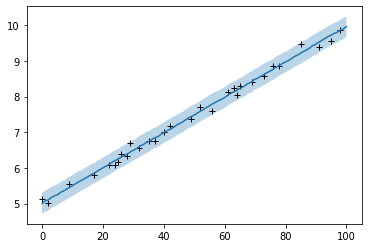

In [41]:
plt.plot(data_sel.day, data_sel.obs, "+", color="black")
plt.plot(x[0:100], np.mean(obs, axis=0))
plt.fill_between(x[0:100], np.mean(obs, axis=0)-np.std(obs, axis=0), np.mean(obs, axis=0)+np.std(obs, axis=0), alpha=0.3)

In [42]:
import arviz as az

In [43]:
data_ana = az.from_numpyro(mcmc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a042abe80>,
      dtype=object)

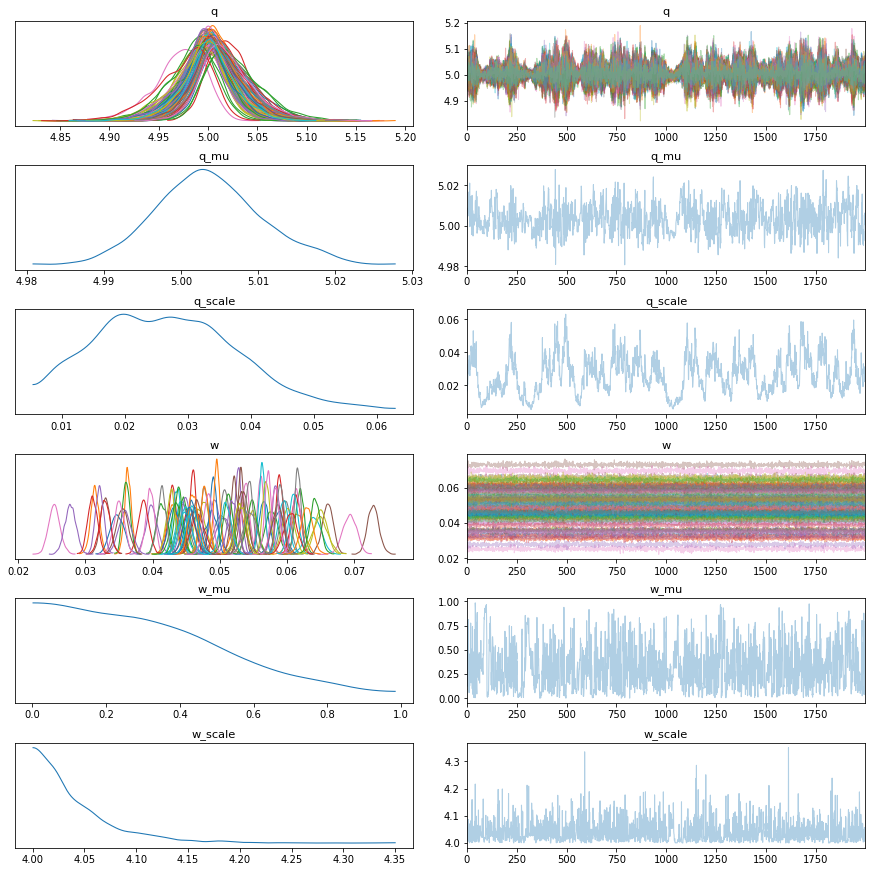

In [44]:
az.plot_trace(data_ana, compact=True)

In [45]:
data_ana

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [46]:
results_points.keys()

dict_keys(['obs', 'q', 'q_mu', 'q_scale', 'w', 'w_mu', 'w_scale'])

In [47]:
results_points["obs"].shape

(2000, 3000)

In [48]:
pull = (np.mean(results_points["obs"], axis=0)-data.obs.values)/(np.std(results_points["obs"], axis=0))

In [49]:
import scipy.stats as stats

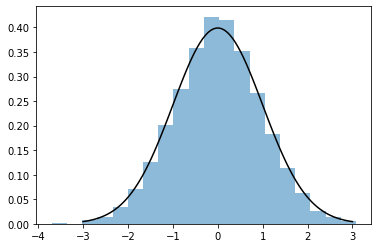

In [50]:
plt.hist(pull, bins=20, density=True, alpha=0.5)
plt.plot(np.linspace(-3., 3., 100), stats.norm.pdf(np.linspace(-3., 3., 100), 0, 1.), color="black")